# DFT 格点

这一节我们考虑 DFT 格点。我们会学习 PySCF 的格点生成程序，以及初步了解 pyxdh 的格点使用方法。

我们知道，量化程序最重要的部分之一是处理积分。我们在之前已经了解过电子积分的导出方式；电子积分是解析地给出，我们曾经也在习题中尝试过 $s$ 轨道重叠积分的计算。但对于 DFT 的积分，由于解析形式不像高斯函数一样容易推导，因此几乎使用的都是数值积分。

现在绝大多数量化程序在处理 DFT 问题时，都使用 Lebedev 格点进行格点积分。

In [1]:
%matplotlib notebook

import numpy as np
import time
from pyscf import gto, lib, dft
from functools import partial

from pyxdh.Utilities.test_molecules import Mol_H2O2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(5, suppress=True, linewidth=120)
np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])

## 数值积分概念

我们现在对以下函数与区间作积分：

$$
\sin(x) , \quad x \in \left[ 0, \pi \right]
$$

显然，根据普通的微积分原理，我们知道

$$
\int_0^\pi \sin(x) \, \mathrm{d} x = \cos(x) |_{x = 0}^\pi = 2
$$

积分可以看作是对微元的加和；如果这些微元都具有相等宽度 $\Delta x$，那么上述积分还可以写为

$$
\int_0^\pi \sin(x) \, \mathrm{d} x \sim \sum_{g = 0}^\frac{\pi}{\Delta x} \sin(g \Delta x) \Delta x
$$

如果我们定义数列 $\{x_g\}$，其中 $x_g = g \Delta x$，那么上式可以简单地重新写为

$$
\int_0^\pi \sin(x) \, \mathrm{d} x \sim \sum_g \sin(x_g) \Delta x
$$

现在，我们定义 `Delta_x` $\Delta x$，以及 `x_list` $\{x_g\}$；那么我们可以立即通过上式求取数值积分：

In [2]:
Delta_x = 0.00001
x_list = np.arange(0, np.pi, Delta_x)
np.sin(x_list).sum() * Delta_x

1.9999999999930804

数值积分一般随着精度越大，即 $\Delta x$ 越小，结果越精确；但相对地，所需要消耗的时间会更多：

In [3]:
for e in np.arange(1, 8):
    time0 = time.time()
    Delta_x = 1 / 10**e
    x_list = np.arange(0, np.pi, Delta_x)
    result = np.sin(x_list).sum() * Delta_x
    print("Delta: 1e{}, Error: 1e{:6.3f}, Time: 1e{:6.3f}"
          .format(e, np.log10(np.abs(2 - result)), np.log10(time.time() - time0)))

Delta: 1e1, Error: 1e-3.345, Time: 1e-2.635
Delta: 1e2, Error: 1e-5.001, Time: 1e-4.223
Delta: 1e3, Error: 1e-7.338, Time: 1e-3.456
Delta: 1e4, Error: 1e-8.877, Time: 1e-3.092
Delta: 1e5, Error: 1e-11.160, Time: 1e-2.297
Delta: 1e6, Error: 1e-13.270, Time: 1e-1.201
Delta: 1e7, Error: 1e-14.239, Time: 1e-0.197


需要指出，由于进入第一个循环时，代码可能需要作准备，因此第一个循环所消耗的时间会相对较多。

## PySCF 格点生成

在上一小节，我们已经了解了对于单一维度 $x$ 的函数 $f(x)$ 的数值积分。事实上，DFT 也使用类似的做法实现数值积分。通常来说，若 DFT 的交换相关核 (Kernel) 是 $f[\rho(\boldsymbol{r})]$，那么交换相关能则表示为

$$
E_\mathrm{xc} [\rho] = \int f[\rho] \rho(\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
$$

与上一节的讨论不同之处在于，这里的积分是三维积分，且被积空间是全空间而非有界区间。

处理这种积分的方式，通常是构造 Lebedev 格点，对其进行加权求和：

$$
E_\mathrm{xc} [\rho] = \sum_{g} w_g f_g [\rho] \rho_g
$$

其中，上式中的 $g$ 代表三维空间上的格点，其坐标是 $\boldsymbol{r}_g$。因此，$f_g [\rho] = f[\rho(\boldsymbol{r})]$ 即在格点 $g$ 处的交换相关核的值，$\rho_g = \rho(\boldsymbol{r})$ 即是在格点 $g$ 处的电子密度。$w_g$ 是 $g$ 处的格点积分权重，它相当于上一小节中的 $\Delta x$；只是上一小节中，每个格点的权重都相同，但这里的 $w_g$ 会因为 $g$ 的不同而不同。

这一小节我们主要展示格点与格点权重；与格点积分有关的计算将放在下一节。下面我们用更为实际的例子来描述格点。现在我们拿出一直使用的双氧水分子：

In [4]:
mol = Mol_H2O2().mol

在 PySCF 通过 `dft.Grids` 生成格点。尽管我们以后会经常使用 (75, 302) 或 (99, 590) 的格点，但在这里为了方便显示，使用 (4, 14) 格点。

In [5]:
grids = dft.Grids(mol)
grids.atom_grid = (4, 14)
grids.build()

DFT 的格点通常是以每个原子为原点的 Lebedev 格点构成的。Lebedev 格点可以看作是一种球形散布的格点。以 (4, 14) 格点为例，4 表示径向的格点分割，14 表示球面格点分割，一共 $4 \times 14 = 56$ 个格点。由于双氧水分子一共有 4 个原子，因此总格点数为 $56 \times 4 = 224$。

In [6]:
grids.weights.size

224

现在我们分析前 56 个格点；这 56 个格点是第一个氧原子 (坐标为 $(x, y, z) = (0, 0, 0)$) 的格点，该氧原子也恰好处于原点上。格点的坐标可以通过 `coords` 方法给出：

In [7]:
grids.coords[:56].shape

(56, 3)

作为示例，其中一些格点的坐标表示如下，其单位是 Bohr 半径：

In [8]:
grids.coords[:4]

array([[0.05362, 0.     , 0.     ],
       [0.48988, 0.     , 0.     ],
       [1.80214, 0.     , 0.     ],
       [4.83583, 0.     , 0.     ]])

下面两行代码表明，所有 56 个格点与原点 (第一个氧原子中心) 的距离只会是上述四个点与原点距离的其中一个。

In [9]:
r_coord = np.linalg.norm(grids.coords[:56], axis=1)
np.allclose(r_coord, r_coord[:4, None].repeat(14, axis=1).T.ravel())

True

下面四行代码表明，所有 56 个格点与原点之间的距离缩放到单位长度 (Bohr 半径) 时，只会有 14 中球面分布。

In [10]:
reshaped_coord = grids.coords[:56].reshape(14, 4, 3)
rescaled_coord = reshaped_coord / np.linalg.norm(reshaped_coord, axis=2)[:, :, None]
for i in range(3):
    print(np.allclose(rescaled_coord[:, 3], rescaled_coord[:, i]))

True
True
True


下面我们展示处于原点上的氧原子所对应的 (14, 6) 格点：

In [11]:
def graph_6p(coords):
    return coords[[0, 2, 1, 3, 0, 4, 1, 5, 0, 2, 4, 3, 5, 2]].T

def graph_8p(coords):
    return coords[[0, 2, 3, 1, 0, 4, 6, 2, 6, 7, 3, 7, 5, 1, 5, 4]].T

<IPython.core.display.Javascript object>


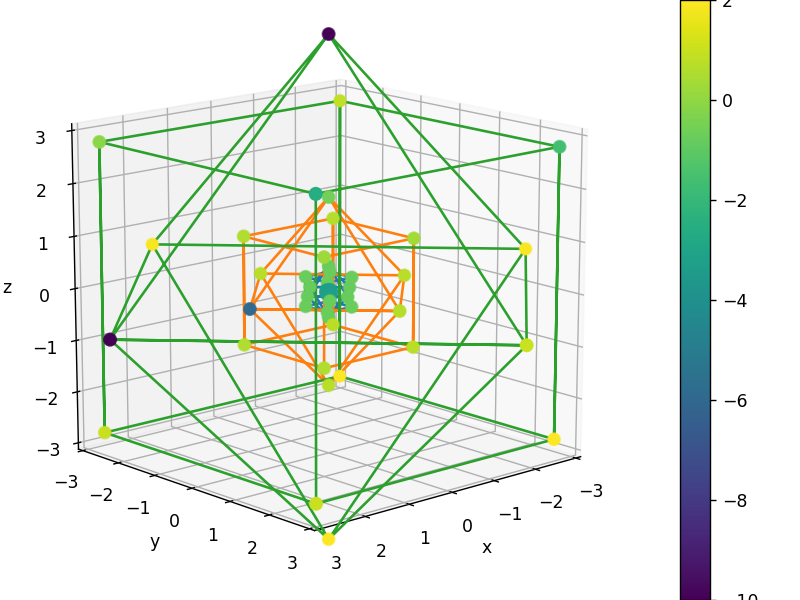

In [12]:
xs, ys, zs = grids.coords[:56].T
log_weights = np.log10(grids.weights[:56] + 1e-10)
fig = plt.figure()
ax = Axes3D(fig)
p = ax.scatter(xs, ys, zs, c=log_weights, s=50)

ax.plot(*graph_6p(grids.coords[1:24:4]), c="C0")
ax.plot(*graph_8p(grids.coords[25:56:4]), c="C0")
ax.plot(*graph_6p(grids.coords[2:24:4]), c="C1")
ax.plot(*graph_8p(grids.coords[26:56:4]), c="C1")
ax.plot(*graph_6p(grids.coords[3:24:4]), c="C2")
ax.plot(*graph_8p(grids.coords[27:56:4]), c="C2")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-3, 3])

ax.view_init(elev=15, azim=48)
fig.colorbar(p)

其中，距离原点 0.05362 Bohr 的格点由于离原点太近没有表示出来；距离 0.48988, 1.80214, 4.83583 的点分别用蓝色、橙色、绿色的直线连接。对于球面上为 14 个格点的情形，这 14 个点恰好所有点分属一个立方体与一个正八面体的顶点。

格点小球上的颜色与右侧以 10 为底数的色条对应；颜色越紫，格点权重越低。在 $x$ 与 $z$ 轴正方向上，由于有其它原子，因此靠近这些方向的格点权重较低。

最后我们展示整个双氧水分子的格点分布情况，其中用分子的骨架用蓝色线条连接。

<IPython.core.display.Javascript object>


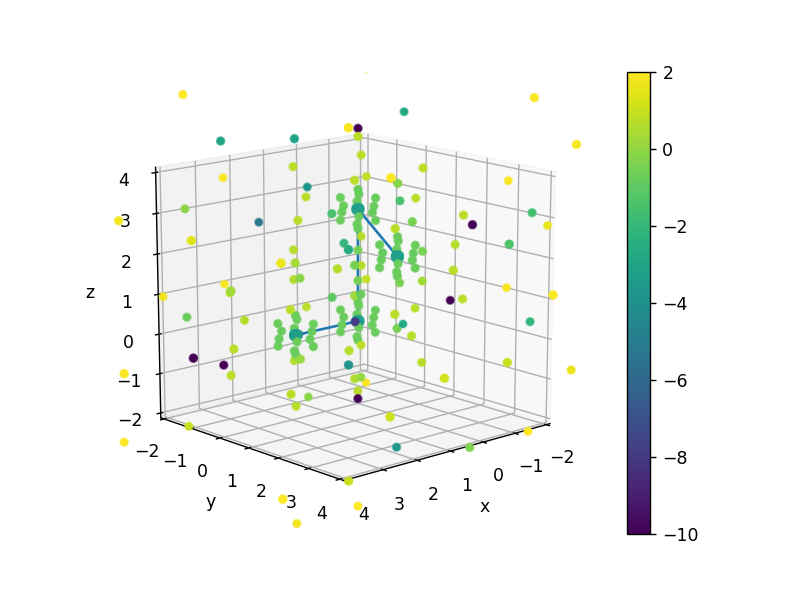

In [13]:
xs, ys, zs = grids.coords.T
axs, ays, azs = mol.atom_coords()[[2, 0, 1, 3]].T
log_weights = np.log10(grids.weights + 1e-10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xs, ys, zs, c=log_weights)
ax.plot(axs, ays, azs)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim([-2, 4])
ax.set_ylim([-2, 4])
ax.set_zlim([-2, 4])
ax.view_init(elev=15, azim=48)
fig.colorbar(p)